In [24]:
import pandas as pd
from sklearn.model_selection import train_test_split
from catboost import CatBoostClassifier
from sklearn.metrics import accuracy_score, classification_report
import matplotlib.pyplot as plt

In [22]:
# --- 1) Load dataset ---
import pandas as pd
DATA_PATH = "WA_Fn-UseC_-Telco-Customer-Churn.csv"  # <-- change this path if your file is elsewhere
df = pd.read_csv(DATA_PATH)
print("Loaded rows:", len(df))
df.head()


Loaded rows: 7043


,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [23]:
# --- 2) Basic cleaning & types ---
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')
print("Missing per column before drop:\\n", df.isnull().sum())
df = df.dropna().copy()
df = df.drop(columns=['customerID'], errors='ignore')   # customerID is not predictive
df['Churn'] = df['Churn'].map({'Yes':1, 'No':0})        # target to 0/1
df.info()


Missing per column before drop:\n customerID           0
gender               0
SeniorCitizen        0
Partner              0
Dependents           0
tenure               0
PhoneService         0
MultipleLines        0
InternetService      0
OnlineSecurity       0
OnlineBackup         0
DeviceProtection     0
TechSupport          0
StreamingTV          0
StreamingMovies      0
Contract             0
PaperlessBilling     0
PaymentMethod        0
MonthlyCharges       0
TotalCharges        11
Churn                0
dtype: int64
<class 'pandas.core.frame.DataFrame'>
Index: 7032 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   gender            7032 non-null   object 
 1   SeniorCitizen     7032 non-null   int64  
 2   Partner           7032 non-null   object 
 3   Dependents        7032 non-null   object 
 4   tenure            7032 non-null   int64  
 5   PhoneService      7032 non-null   

EDA (charts)

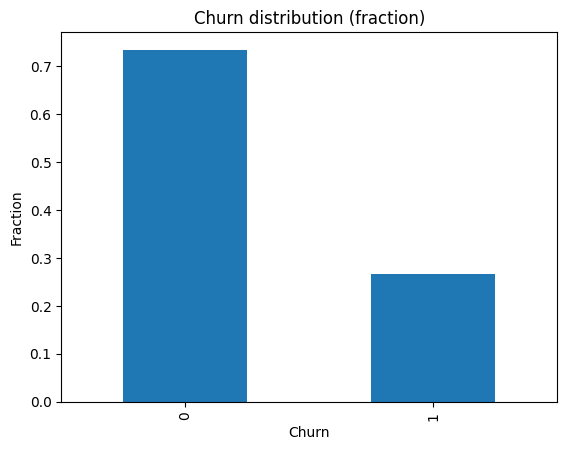

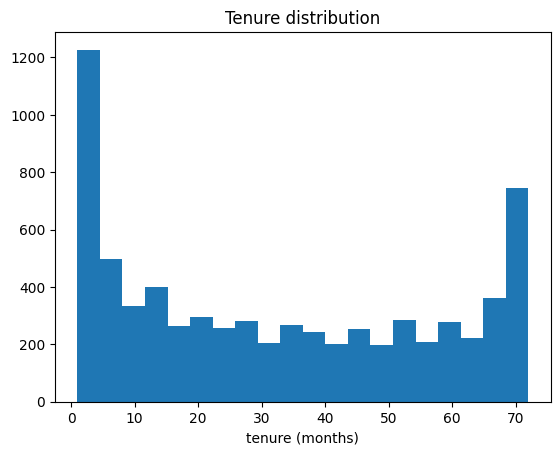

<Figure size 640x480 with 0 Axes>

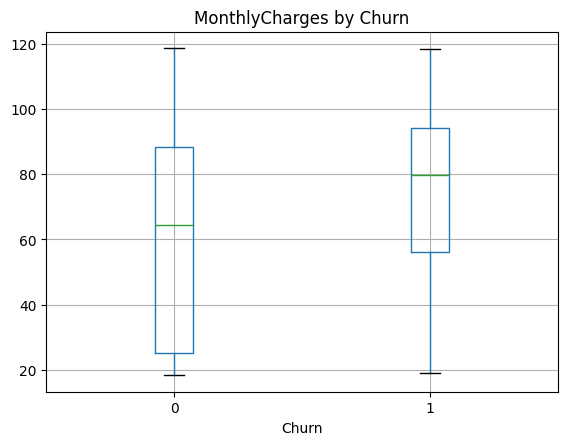

                  tenure  MonthlyCharges  TotalCharges     Churn
tenure          1.000000        0.246862      0.825880 -0.354049
MonthlyCharges  0.246862        1.000000      0.651065  0.192858
TotalCharges    0.825880        0.651065      1.000000 -0.199484
Churn          -0.354049        0.192858     -0.199484  1.000000


In [25]:
# 1) Churn distribution
plt.figure()
df['Churn'].value_counts(normalize=True).plot(kind='bar')
plt.title('Churn distribution (fraction)')
plt.xlabel('Churn')
plt.ylabel('Fraction')
plt.show()

# 2) Tenure distribution
plt.figure()
plt.hist(df['tenure'], bins=20)
plt.title('Tenure distribution')
plt.xlabel('tenure (months)')
plt.show()

# 3) MonthlyCharges by Churn (boxplot)
plt.figure()
df.boxplot(column='MonthlyCharges', by='Churn')
plt.suptitle('')
plt.title('MonthlyCharges by Churn')
plt.show()

# 4) Correlation of numeric features
print(df[['tenure','MonthlyCharges','TotalCharges','Churn']].corr())

Feature engineering

In [26]:
# --- 4) Feature engineering ---
# Create some useful features
df['TotalSpent'] = df['MonthlyCharges'] * df['tenure']

# tenure bins
bins = [0, 12, 24, 48, 72]
labels = ['0-12','12-24','24-48','48+']
df['tenure_bin'] = pd.cut(df['tenure'], bins=bins, labels=labels, include_lowest=True)

# Contract strength numeric (optional)
contract_map = {'Month-to-month': 0, 'One year': 1, 'Two year': 2}
if 'Contract' in df.columns:
    df['Contract_num'] = df['Contract'].map(contract_map)

# Quick view
df[['tenure','tenure_bin','MonthlyCharges','TotalCharges','TotalSpent','Contract','Contract_num']].head()


,tenure,tenure_bin,MonthlyCharges,TotalCharges,TotalSpent,Contract,Contract_num
0,1,0-12,29.85,29.85,29.85,Month-to-month,0
1,34,24-48,56.95,1889.50,1936.30,One year,1
2,2,0-12,53.85,108.15,107.70,Month-to-month,0
3,45,24-48,42.30,1840.75,1903.50,One year,1
4,2,0-12,70.70,151.65,141.40,Month-to-month,0


Train/Test Split

In [27]:
# --- 5) Prepare train/test split ---
from sklearn.model_selection import train_test_split
X = df.drop('Churn', axis=1)
y = df['Churn']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
print("Train shape:", X_train.shape, "Test shape:", X_test.shape)


Train shape: (5625, 22) Test shape: (1407, 22)


Identify categorical columns

In [28]:
# --- 6) Identify categorical columns for CatBoost ---
cat_cols = X.select_dtypes(include=['object','category']).columns.tolist()
# ensure tenure_bin included if present
if 'tenure_bin' in X.columns and 'tenure_bin' not in cat_cols:
    cat_cols.append('tenure_bin')
print('Categorical columns detected (for CatBoost):', cat_cols)


Categorical columns detected (for CatBoost): ['gender', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod', 'tenure_bin']


Train CatBoost Model (Best for categorical features)

In [29]:
# Choose class weights based on imbalance. Example: [1, 3]
model_cb = CatBoostClassifier(
    depth=6,
    learning_rate=0.05,
    iterations=800,
    class_weights=[1, 3],   
    verbose=100
)

# Fit model with specified categorical columns
model_cb.fit(X_train, y_train, cat_features=cat_cols)

0:	learn: 0.6720321	total: 67.3ms	remaining: 53.8s
100:	learn: 0.4501723	total: 6.28s	remaining: 43.5s
200:	learn: 0.4268858	total: 12.6s	remaining: 37.5s
300:	learn: 0.3978011	total: 19.9s	remaining: 33s
400:	learn: 0.3727541	total: 27.6s	remaining: 27.5s
500:	learn: 0.3515601	total: 34.5s	remaining: 20.6s
600:	learn: 0.3346548	total: 42.4s	remaining: 14.1s
700:	learn: 0.3183373	total: 49.6s	remaining: 7.01s
799:	learn: 0.3040316	total: 56s	remaining: 0us


Evaluate CatBoost

In [30]:
# --- 8) Evaluation on test set (CatBoost) ---
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score, confusion_matrix
pred = model_cb.predict(X_test)
probs = model_cb.predict_proba(X_test)[:,1]
print("Accuracy:", accuracy_score(y_test, pred))
print("AUC:", roc_auc_score(y_test, probs))
print(classification_report(y_test, pred))
print("Confusion matrix:\\n", confusion_matrix(y_test, pred))


Accuracy: 0.7306325515280739
AUC: 0.8287437037650579
              precision    recall  f1-score   support

           0       0.90      0.71      0.80      1033
           1       0.50      0.78      0.60       374

    accuracy                           0.73      1407
   macro avg       0.70      0.74      0.70      1407
weighted avg       0.79      0.73      0.74      1407

Confusion matrix:\n [[738 295]
 [ 84 290]]


Alternative: SMOTE oversampling + LightGBM

In [31]:
# --- 9) Alternative approach: SMOTE + LightGBM ---
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import LabelEncoder
import lightgbm as lgb

# Prepare copies
X_num = X_train.copy()
X_test_num = X_test.copy()

# Label-encode categorical columns for LightGBM
le_dict = {}
for c in cat_cols:
    le = LabelEncoder()
    # convert to string to avoid issues like nan
    X_num[c] = le.fit_transform(X_num[c].astype(str))
    X_test_num[c] = le.transform(X_test_num[c].astype(str))
    le_dict[c] = le

# Apply SMOTE
sm = SMOTE(random_state=42)
X_res, y_res = sm.fit_resample(X_num, y_train)
print('Resampled shape:', X_res.shape)

# Train LightGBM
lgbm = lgb.LGBMClassifier(n_estimators=500, learning_rate=0.05)
lgbm.fit(X_res, y_res)

# Evaluate LightGBM
pred_lgb = lgbm.predict(X_test_num)
probs_lgb = lgbm.predict_proba(X_test_num)[:,1]
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report
print('LightGBM (SMOTE) Accuracy:', accuracy_score(y_test, pred_lgb))
print('LightGBM (SMOTE) AUC:', roc_auc_score(y_test, probs_lgb))
print(classification_report(y_test, pred_lgb))


Resampled shape: (8260, 22)
[LightGBM] [Info] Number of positive: 4130, number of negative: 4130
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001375 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 888
[LightGBM] [Info] Number of data points in the train set: 8260, number of used features: 22
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
LightGBM (SMOTE) Accuracy: 0.7555081734186212
LightGBM (SMOTE) AUC: 0.8060889056846007
              precision    recall  f1-score   support

           0       0.84      0.82      0.83      1033
           1       0.54      0.57      0.55       374

    accuracy                           0.76      1407
   macro avg       0.69      0.70      0.69      1407
weighted avg       0.76      0.76      0.76      1407



Feature importance (CatBoost)

          Feature Id  Importances
0     MonthlyCharges    11.456890
1             tenure    11.400406
2       TotalCharges     9.111509
3       Contract_num     7.897495
4         TotalSpent     7.445063
5      PaymentMethod     5.838551
6    InternetService     5.368452
7           Contract     4.823989
8         tenure_bin     4.430970
9     OnlineSecurity     4.401752
10     MultipleLines     4.285642
11       TechSupport     3.480201
12       StreamingTV     3.407619
13      OnlineBackup     2.874980
14            gender     2.838947
15   StreamingMovies     2.321692
16  PaperlessBilling     2.101456
17  DeviceProtection     2.036567
18        Dependents     1.831555
19     SeniorCitizen     1.285660
20           Partner     1.002872
21      PhoneService     0.357732


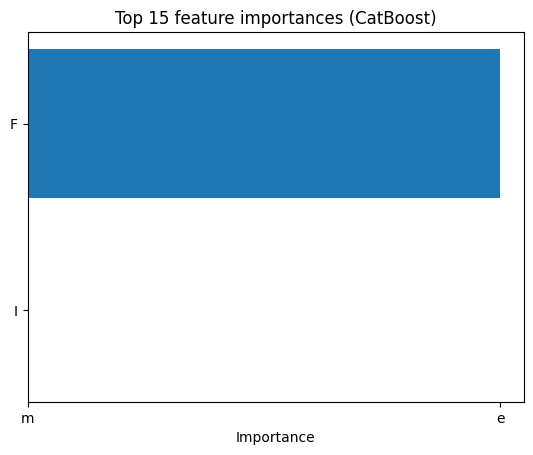

In [32]:
# --- 10) Feature importance (CatBoost) ---
fi = model_cb.get_feature_importance(prettified=True)
print(fi)
# Optionally plot top features:
import matplotlib.pyplot as plt
feat_names = [f[0] for f in fi]
scores = [f[1] for f in fi]
plt.figure()
plt.barh(feat_names[::-1][:15], scores[::-1][:15])
plt.title('Top 15 feature importances (CatBoost)')
plt.xlabel('Importance')
plt.show()


Save the model

In [34]:
# --- 11) Save model to file for later use ---
model_cb.save_model('catboost_customer_churn.cbm')
print('Saved model to catboost_customer_churn.cbm')


Saved model to catboost_customer_churn.cbm
